# CNN Training

Train a CNN network to extract the needle position of an analog pointer

### Basic Parameter

Note: Do not rename any of the variables in this section, because the they are externally used in github action `Train Model`

In [1]:
# Model naming
TFlite_MainType: str = 'ana-class100'
TFlite_Version: str  = '1800'
TFlite_Size: str     = 's2'

# Validation size
# Note: 0.0 = 0% validation size, use all images for training
Validation_Percentage = 0.2

# Folders
Input_Dir: str  = 'data_resize_all'
Output_Dir: str = 'models/ana-class100'


In [2]:
import os
import sys
import glob
from pathlib import Path
import random
import math
import numpy as np
from numpy import pi
import pandas as pd

from PIL import Image

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from src.utils.plot_functions import plot_dataset, plot_dataset_analog


%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


# Make sure version is 4 characters long if version is defined as int (e.g. papermill paramter 100 -> 0100)
if isinstance(TFlite_Version, int):
    TFlite_Version = str(TFlite_Version).zfill(4)


# Prepare folders
if not (Path(Input_Dir).exists() and Path(Input_Dir).is_dir()): # Check if input is availabe
    sys.exit(f"Aborting: Folder '{Input_Dir}' does not exist.")
    
Path(Output_Dir).mkdir(parents=True, exist_ok=True)  # Create output folder if it doesn't exist


# Disable GPUs
try:
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass


### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [3]:
files = glob.glob(f"{Input_Dir}/*.jpg")
num_files = len(files)

f_data = np.empty(num_files, dtype="<U250")
x_data = np.empty((num_files, 32, 32, 3))
y_data = np.empty(num_files)

for i, aktfile in enumerate(files):
    base = os.path.basename(aktfile)

    # get label from filename (1.2_ new or 1_ old),
    if (base[1]=="."):
        target = base[0:3]
    else:
        target = base[0:1]
    category = float(target)
    
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    f_data[i] = aktfile
    x_data[i] = test_image
    y_data[i] = category

print("Data count: ", len(y_data))  
print(x_data.shape)

x_data, y_data, f_data = shuffle(x_data, y_data, f_data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Validation_Percentage)
y_train = keras.utils.to_categorical(y_train*10, 100)
y_test = keras.utils.to_categorical(y_test*10, 100)

print(np.expand_dims(y_data, axis=1).shape)


Data count:  2493
(2493, 32, 32, 3)
(2493, 1)


### Distribution of the data

Uneven distribution of data can lead to poorer results.

In some classes (8.4) we have only 20 images. In other classes over 100 images.

In [4]:
_, inverse = np.unique(y_data, return_inverse=True)
ziffer_bincount = np.bincount(inverse)
fig = plt.figure(figsize=(40, 10))
fig.suptitle("Distribution of data")
plt.bar(np.arange (0, 100/10, 0.1), ziffer_bincount, width=0.09, align='center')
plt.ylabel('count')
plt.xlabel('digit class')
plt.tight_layout()
_ = plt.xticks(np.arange(0, 100/10, 0.1))


### Define the model

The layout of the network ist a typcial CNN network with alternating 2x **Conv2D**, **BatchNormalization** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

**Dropout** between CNN layers are 0.2, between fully connected layers 0.4, but only the fully connected output layer.

* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (100) - classification 0.0 ... 9.9

In [5]:
inputs = Input(shape=(32, 32, 3))
x = BatchNormalization()(inputs)

x = Conv2D(32, (5, 5), padding='same', activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(4, 4))(x)
x = Dropout(0.15)(x)

x = Conv2D(32, (3, 3), padding='same', activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)

x = Conv2D(48, (3, 3), padding='same', activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(4, 4))(x)
x = Dropout(0.15)(x)

x = Conv2D(48, (3, 3), padding='same', activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)

x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.15)(x)

x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(0.3)(x)

# Output layer for 100-class classification
output = Dense(100)(x)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 48)       │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 48)       │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 48)       │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 48)       │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 64)       │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1, 1, 64)       │           25

 Total params: 118,640 (463.44 KB)

 Trainable params: 118,058 (461.16 KB)

 Non-trainable params: 582 (2.27 KB)

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is in one step. 

The best model will be stored as \<modelname\>_best.h5

### Augmentation

Augmentation uses shift, zoom, brightness, shear

Training data


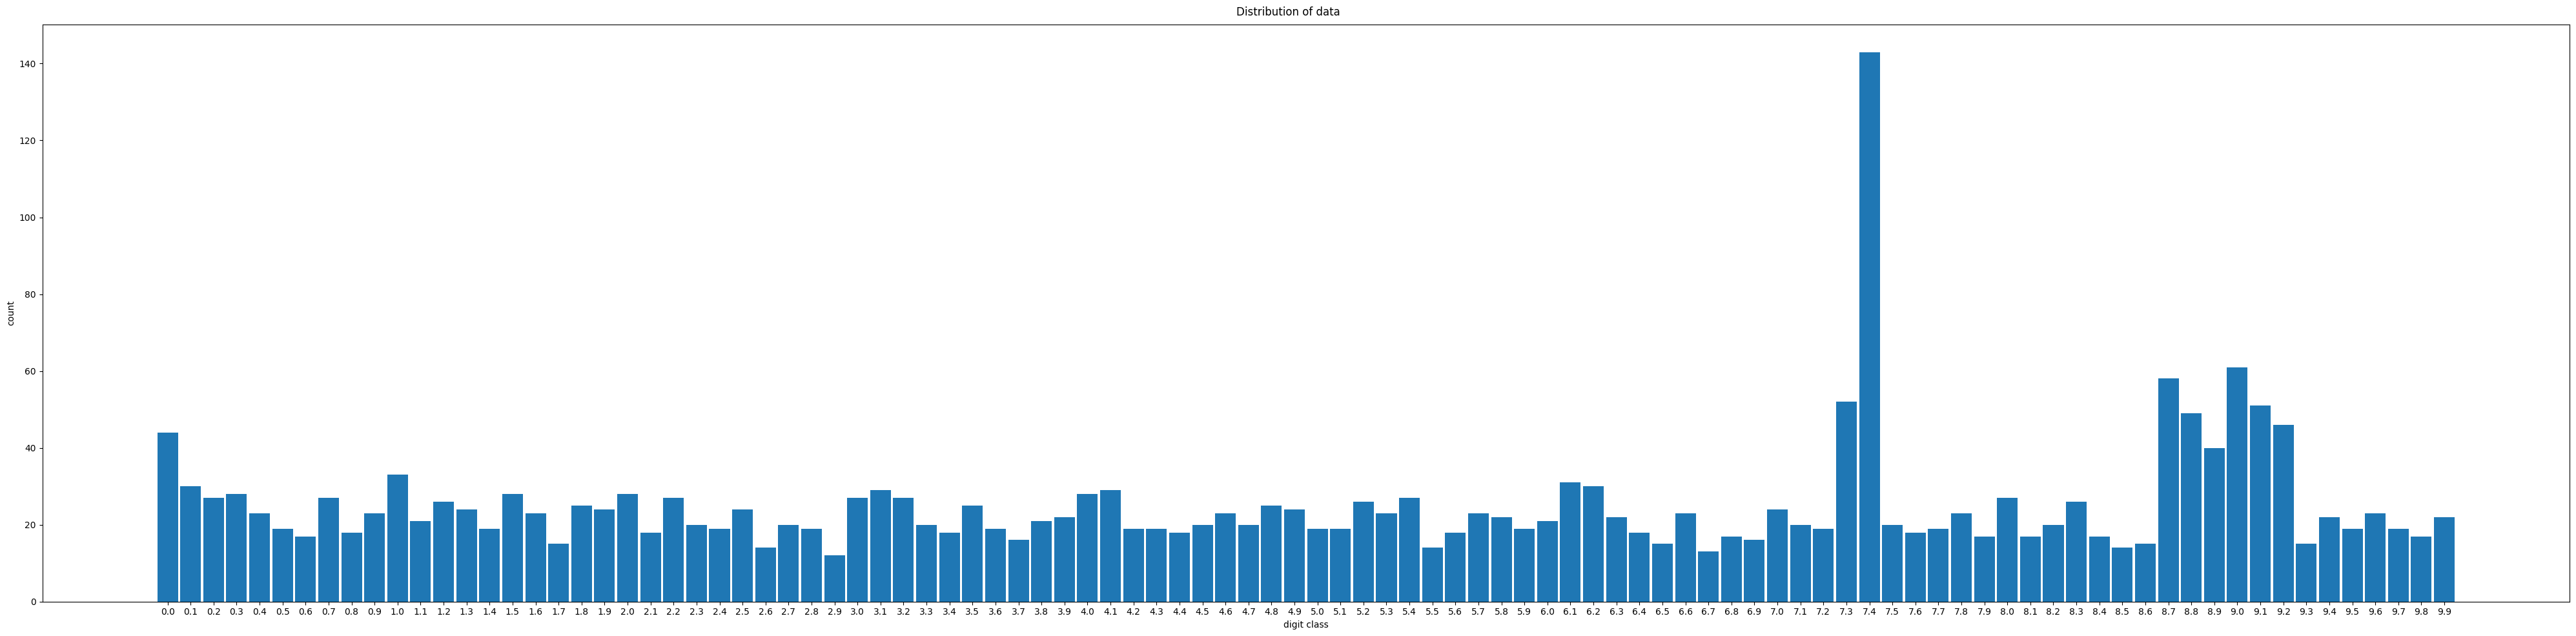

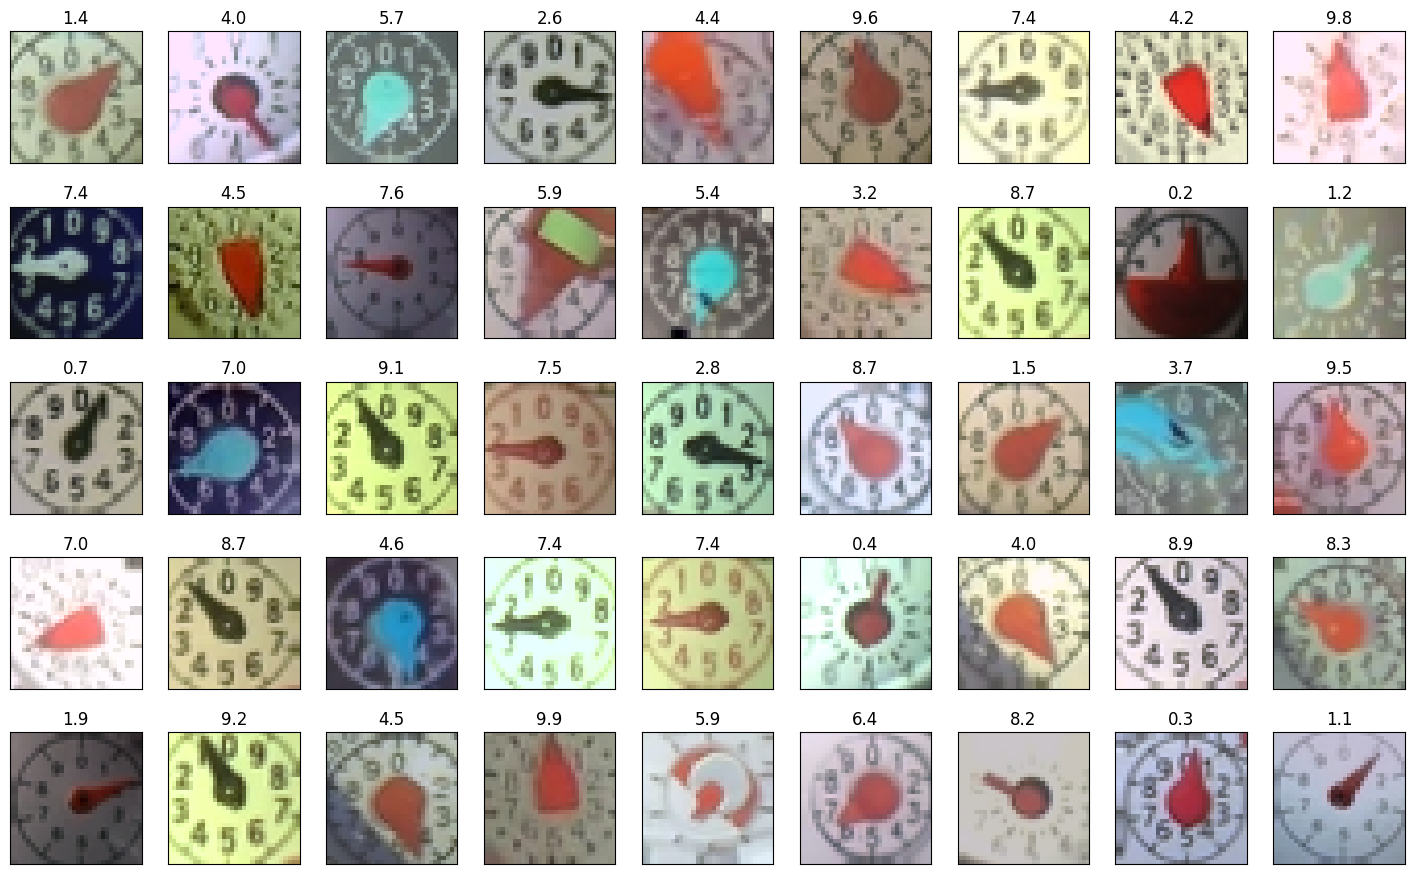

  
Validation data


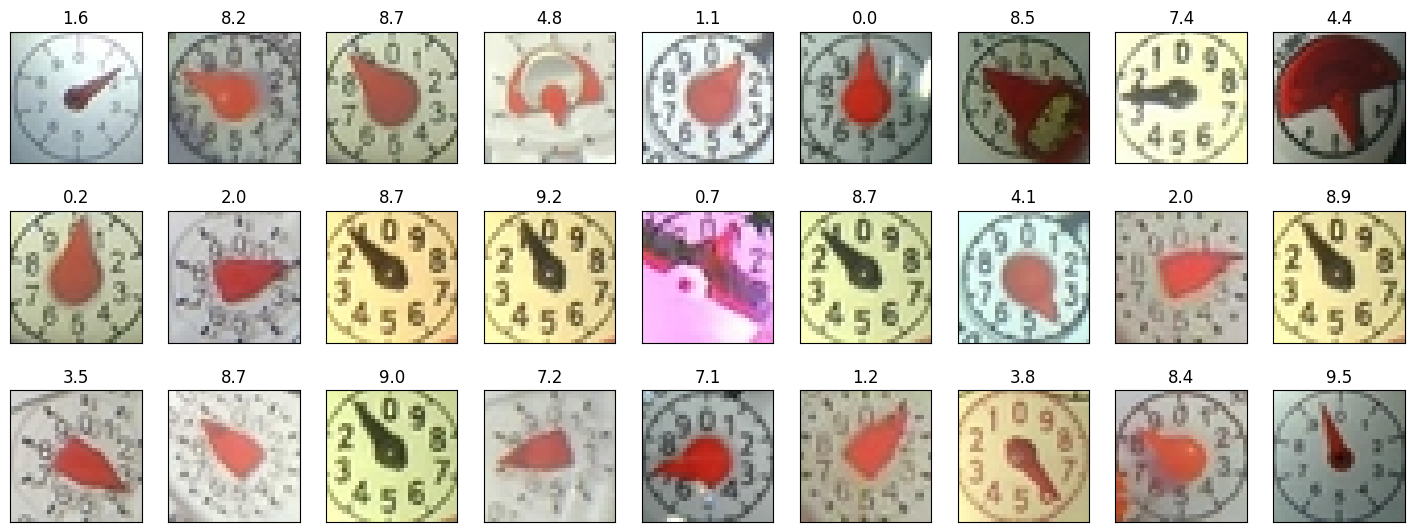

In [6]:
Batch_Size = 8
Shift_Range = 1
Brightness_Range = 0.2
Zoom_Range = 0.05

def random_invert_image(x, probability_invert=0.2):
    """
    Invert an image with a given probability
    """
    if random.random() > probability_invert:
        return x
    return 255 - x  # Invert image

def random_white_balance(x, strength_range=(0.9, 1.1)):
    """
    Simulates poor white balance by randomly scaling RGB channels independently.
    strength_range controls how strong the color cast distortion is.
    """
    x = x.astype(np.float32)

    # Random scaling for each channel (simulates color cast)
    r_scale = np.random.uniform(*strength_range)
    g_scale = np.random.uniform(*strength_range)
    b_scale = np.random.uniform(*strength_range)

    x[..., 0] *= r_scale  # Red channel
    x[..., 1] *= g_scale  # Green channel
    x[..., 2] *= b_scale  # Blue channel

    return x

def preprocessing(x):
    x = random_invert_image(x)
    x = random_white_balance(x)
    x = np.clip(x, 0.0, 255.0)
    return x.astype(np.float32)

# Training data
print("Training data")
datagen = ImageDataGenerator(width_shift_range=[-Shift_Range, Shift_Range], 
                             height_shift_range=[-Shift_Range, Shift_Range],
                             brightness_range=[1 - Brightness_Range, 1 + Brightness_Range],
                             zoom_range=[1 - Zoom_Range, 1 + Zoom_Range],
                             channel_shift_range=5,
                             shear_range=1,
                             preprocessing_function=preprocessing
                            )

train_iterator = datagen.flow(x_train, y_train, batch_size=Batch_Size)
plot_dataset_analog(train_iterator)

if (Validation_Percentage > 0):
    # Validation data
    datagen_val = ImageDataGenerator() # No augmentation for validation
    validation_iterator = datagen_val.flow(x_test, y_test, batch_size=Batch_Size)
    print("  ")
    print("Validation data")
    plot_dataset_analog(validation_iterator, rows=3)


In [7]:
Epoch_Anz = 600

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.9, 
    patience=5, 
    min_lr=1e-5, 
    verbose=0
)

earlystop = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=40, 
    verbose=0,  
    restore_best_weights=True
)

history = model.fit(
    train_iterator, 
    validation_data=validation_iterator, 
    batch_size=Batch_Size, 
    epochs = Epoch_Anz,
    callbacks=[earlystop, reduce_lr],
    verbose=0
)


C:\Users\Muell\anaconda3\envs\py311-tf218\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


### Result
 
* Visualization of the training and validation results
* Validation should not much over train validation, because of the augmentation of train data (validation data not)
* Beware, the best model will be used. This can be from an earlier epoch as the last. (mostly the last -30)


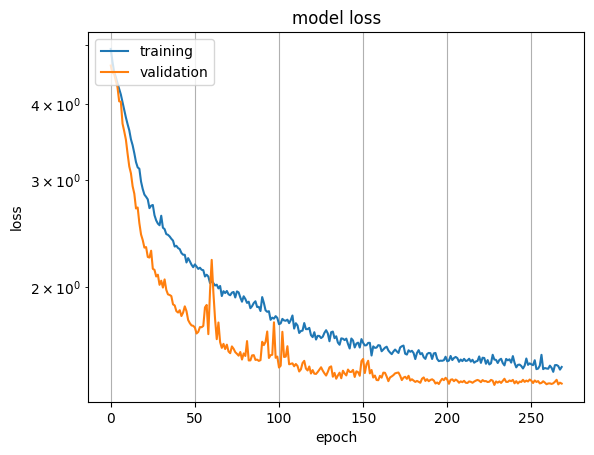

In [8]:
plt.semilogy(history.history['loss'])

if (Validation_Percentage > 0):
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.grid(True)
plt.show()


### Model verification

* The following code uses the trained model to check the deviation for each picture (train + validation).
* The max_delta can be used to get the accuracy with allowed differences (for instance +/- 0.1)
* The first (max) 49 false predicted images will be shown
* A csv-file with all false predicted images will be created. It can be used for relabeling. Usage `python3 -m collectmeteranalog  --labelfile=ana-class100_s1_false_predicted.csv --model=ana-class100_s1q.tflite` (see https://github.com/haverland/collectmeteranalog)


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Accuracy: 94.30405134376254 % (Images: 2493 | False Predicted: 142)


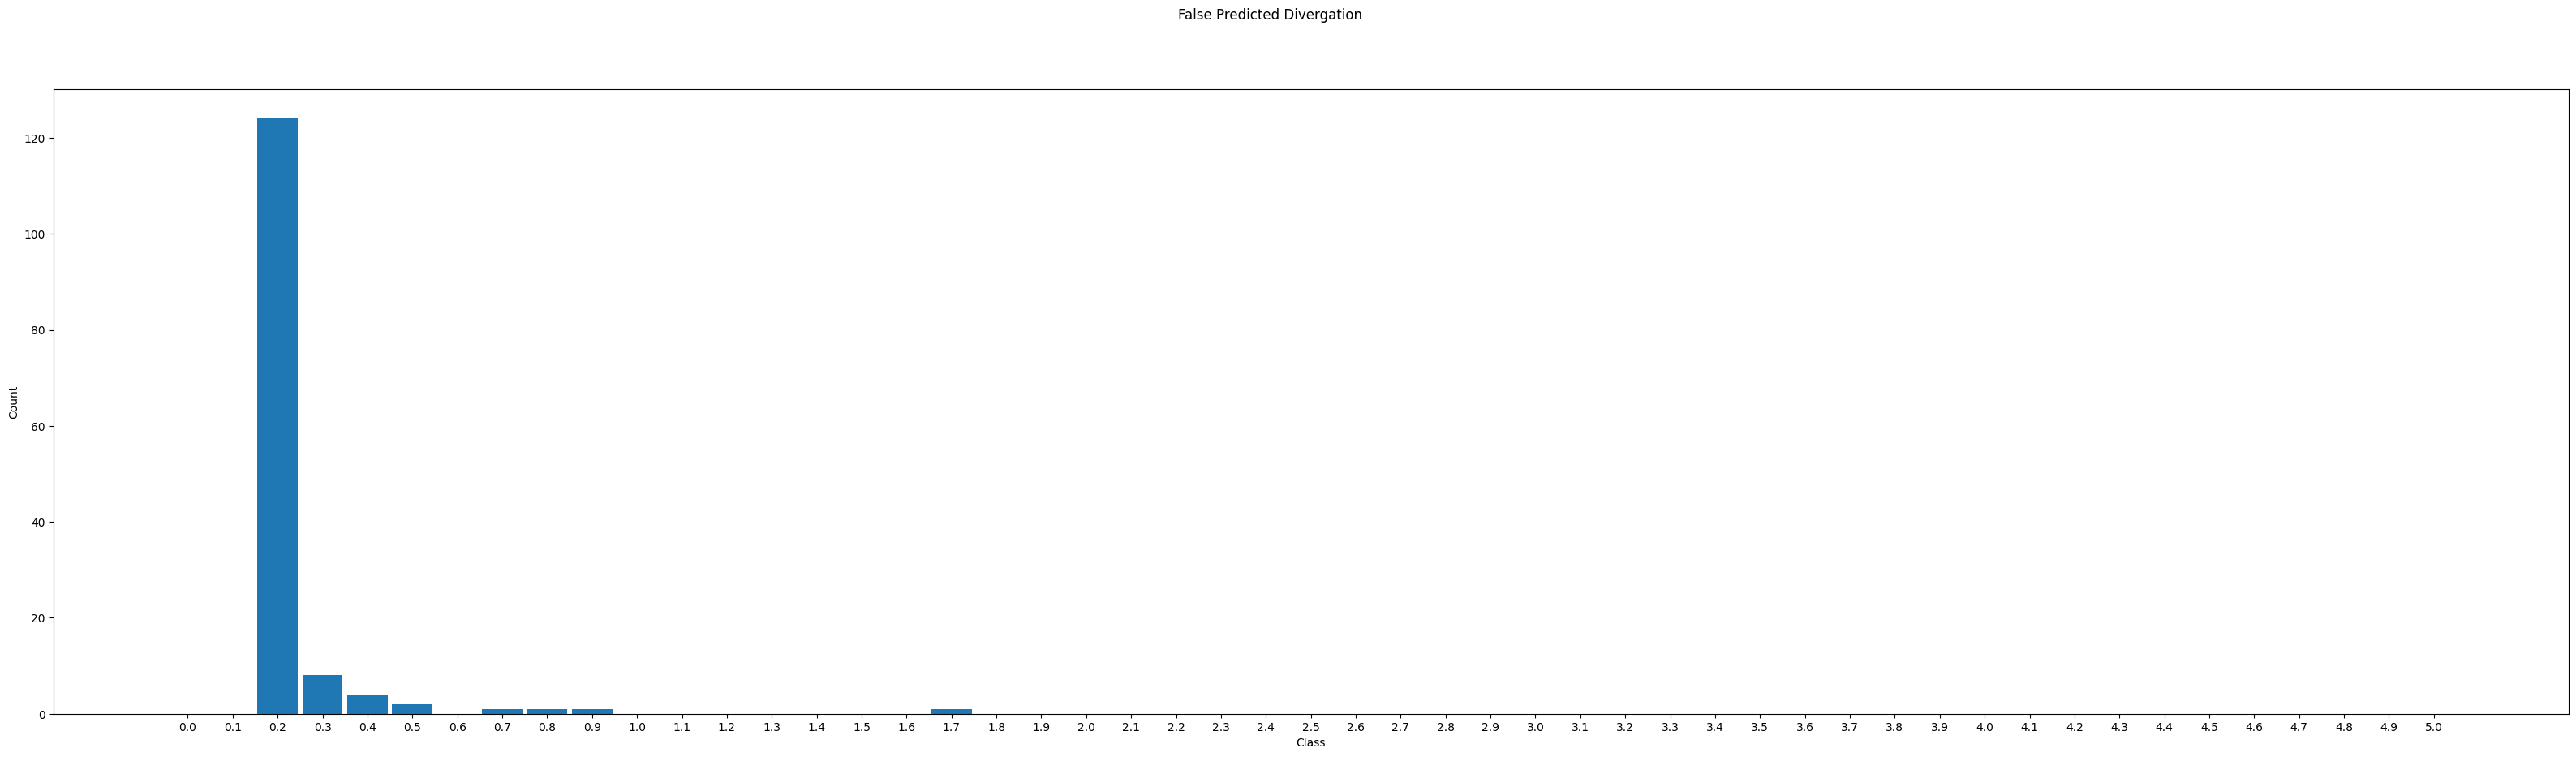

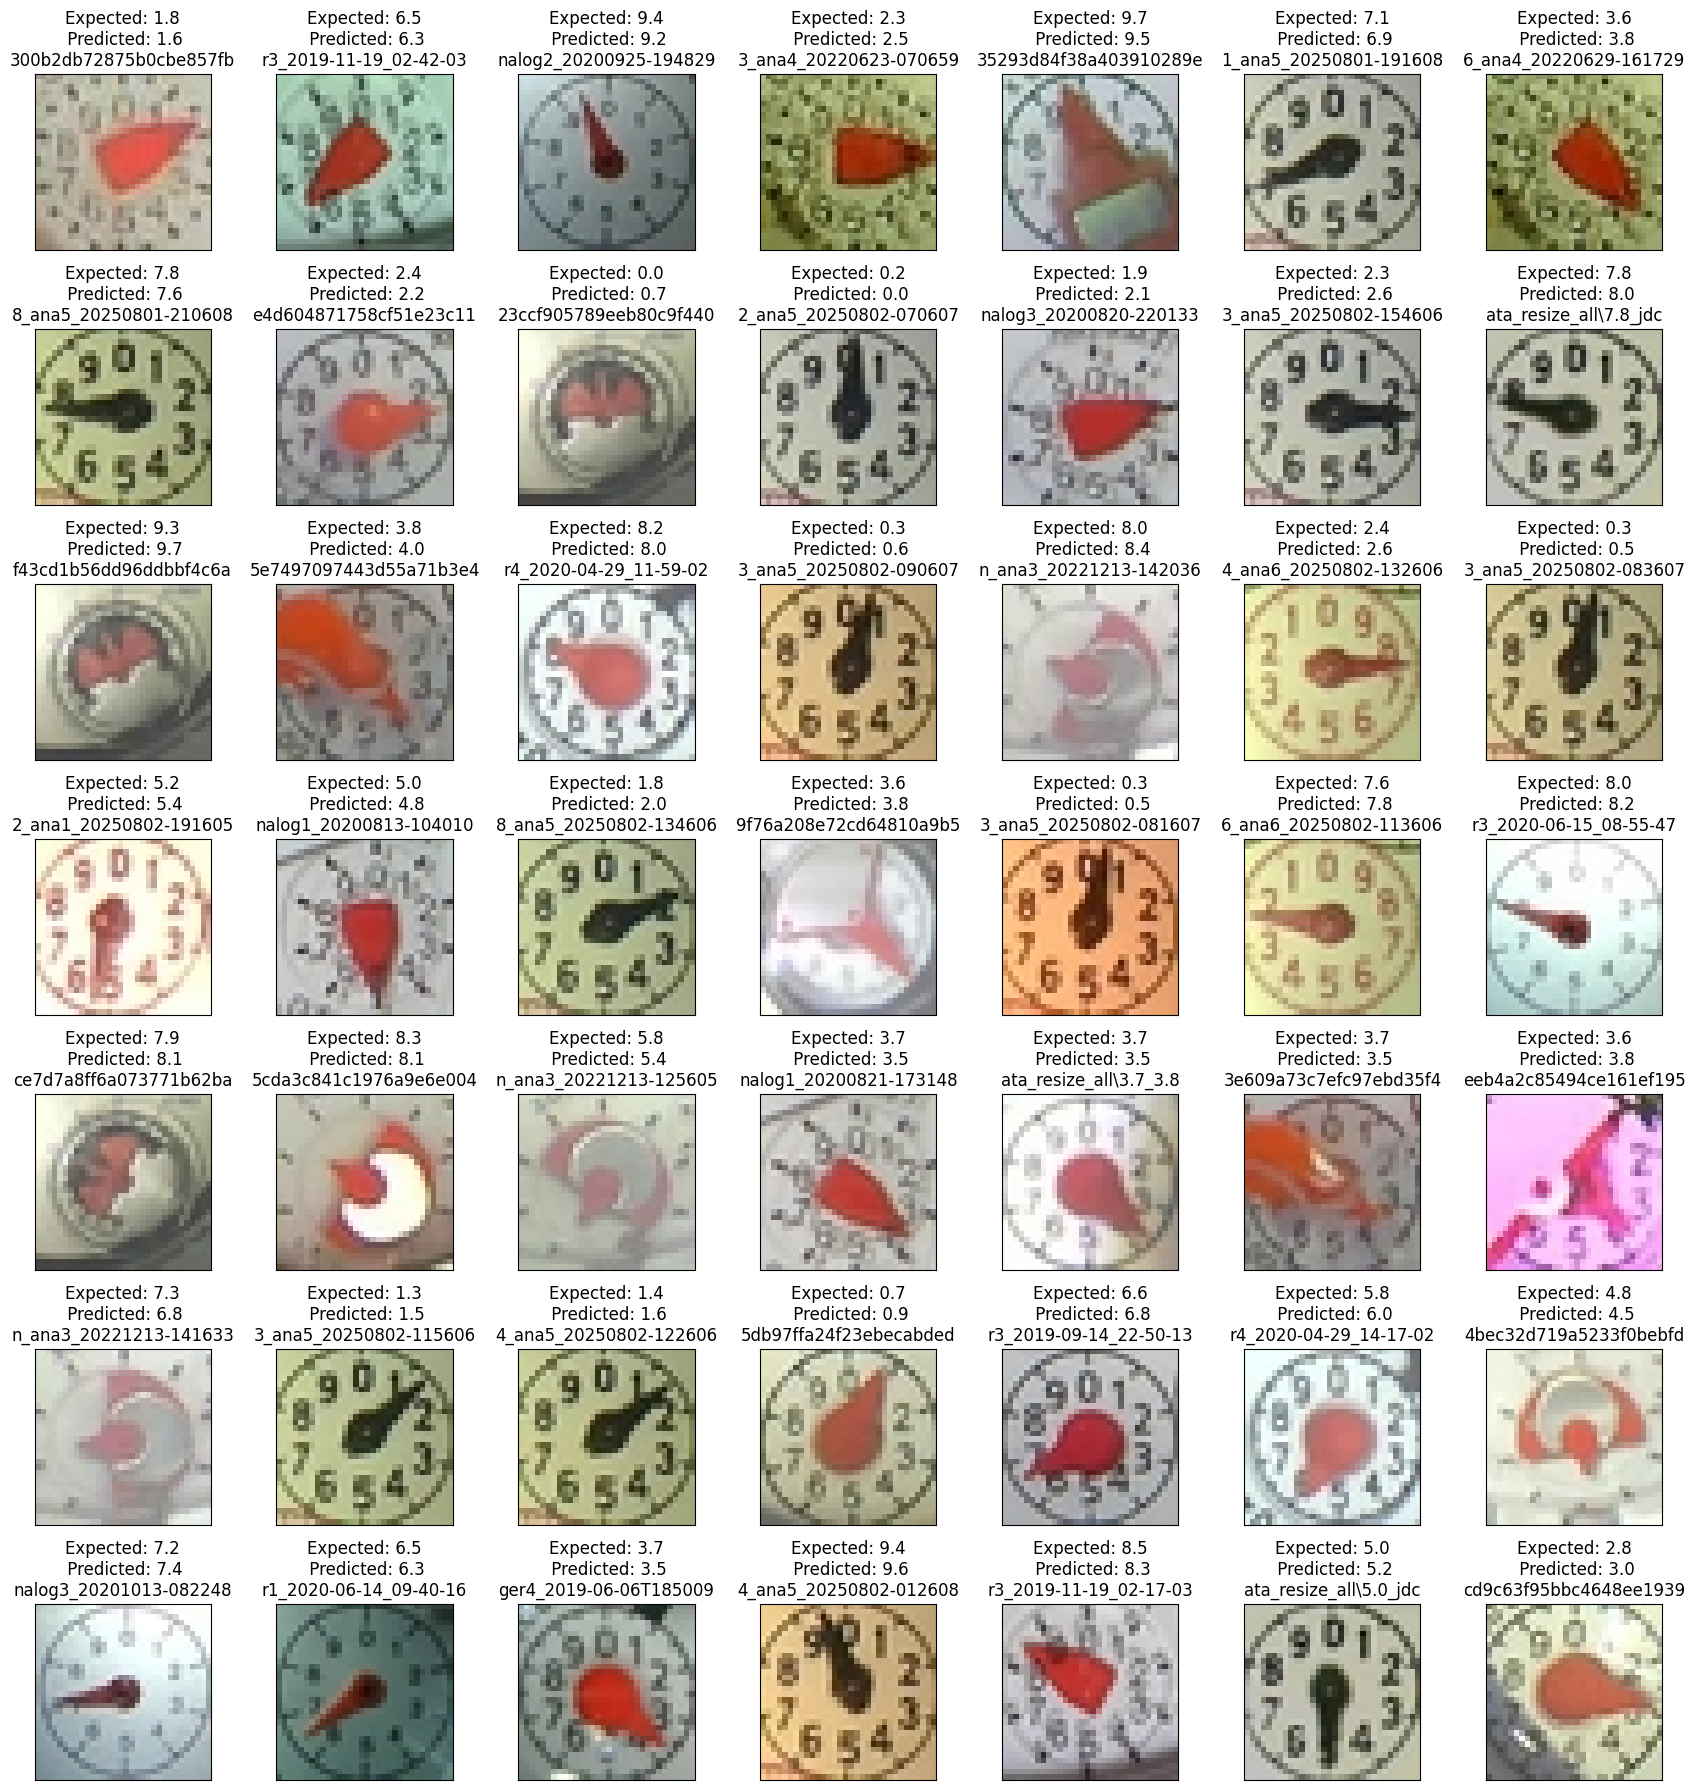

In [9]:
max_delta=0.11

def plot_dataset(images, labels, columns=10, rows=5, figsize=(18, 10)):

    fig = plt.figure(figsize=figsize)
    
    for i in range(1, columns*rows +1):
        if (i>len(labels)):
            break
        fig.add_subplot(rows, columns, i)
        plt.title(labels[i-1])  # set title
        plt.imshow((images[i-1]).astype(np.uint8), aspect='1', extent=[0, 1, 0, 1])
        # yellow lines
        ax=plt.gca()
        ax.get_yaxis().set_visible(False) 
        ax.get_xaxis().set_visible(False) 
        
        plt.tight_layout()
    plt.show()

def plot_divergence(divergationset, title1):
    fig = plt.figure(figsize=(40, 10))
    fig.suptitle(title1)
    plt.bar(np.arange (0, len(divergationset)/10, 0.1), divergationset, width=0.09, align='center')
    plt.ylabel('Count')
    plt.xlabel('Class')
    plt.xticks(np.arange(0, len(divergationset)/10, 0.1))
    return fig

classes = model.predict(x_data.astype(np.float32))
predictions = np.argmax(classes, axis=1).reshape(-1)/10

# 9.9 <> 0 = 0.1 and 1.1 <> 1.2 = 0.1
differences = np.minimum(np.abs(predictions - y_data), np.abs(predictions - (10 - y_data)))
# used for filtering
false_differences = differences > max_delta
# only differences bigger than delta. so small differences can be ignored in early stages
false_predicted = differences[false_differences]
false_images = x_data[false_differences]
false_labels = [ "Expected: " + str(y1) + "\n Predicted: " + str(p) + "\n" + str(f)[-26:-4] for y1, p, 
                f in zip(y_data[false_differences], predictions[false_differences], f_data[false_differences])]
false_files = [ f for f in  f_data[false_differences]]

print(f"Accuracy: {(1 - len(false_predicted) / len(y_data)) * 100.0} % (Images: {len(y_data)} | False Predicted: {len(false_predicted)})")
# plot the differences (max difference can only be 5.0)
plot_divergence(np.bincount(np.array(np.round(false_predicted*10)).astype(int), minlength=51), "False Predicted Divergation")

# plot the false predicted images
plot_dataset(np.array(false_images), false_labels, columns=7, rows=7, figsize=(18,18))
#print(false_files)
fpf = pd.DataFrame(false_files)

# the csv can be used with collectmeterdigits to fix labels
# python3 -m collectmeteranalog  --labelfile=ana-class10_0168_s1_false_predicted.csv --model=ana-class100_0168_s1_q.tflite
fpf.to_csv(f"{Output_Dir}/{TFlite_MainType}_{TFlite_Version}_{TFlite_Size}" + '_false_predicted.csv')


### Save the model

* Save the model to the file with the "tflite" file format
* quantize the model and store it as -q.tflite

In [10]:
FileName = f"{Output_Dir}/{TFlite_MainType}_{TFlite_Version}_{TFlite_Size}.tflite"

# TensorFlow Lite conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open(FileName, "wb") as f:
    f.write(tflite_model)

print(f"Model saved successfully. File: {FileName}")
print(f"File size: {Path(FileName).stat().st_size} bytes")


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpkk9rc694\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpkk9rc694\assets


Saved artifact at 'C:\Users\Muell\AppData\Local\Temp\tmpkk9rc694'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 100), dtype=tf.float32, name=None)
Captures:
  1859129727440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1858818667344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1859129727632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1859129727056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1858818666960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1858818667728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1858818666576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1858818668496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1859129727248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1858818668688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  18588

In [11]:
FileName = f"{Output_Dir}/{TFlite_MainType}_{TFlite_Version}_{TFlite_Size}_q.tflite"

# Representative dataset function
def representative_dataset():
    for n in range(x_data[0].shape[0]):
        data = np.expand_dims(x_data[n], axis=0)
        yield [data.astype(np.float32)]

# TensorFlow Lite conversion with optimizations
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter._experimental_disable_per_channel_quantization_for_dense_layers = True
tflite_quant_model = converter.convert()

# Save the converted model to the specified file
with open(FileName, "wb") as f:
    f.write(tflite_quant_model)

print(f"Model saved successfully. File: {FileName}")
print(f"File size: {Path(FileName).stat().st_size} bytes")


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpcgvvmkyo\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpcgvvmkyo\assets


Saved artifact at 'C:\Users\Muell\AppData\Local\Temp\tmpcgvvmkyo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 100), dtype=tf.float32, name=None)
Captures:
  1859129727440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1858818667344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1859129727632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1859129727056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1858818666960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1858818667728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1858818666576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1858818668496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1859129727248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1858818668688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  18588

C:\Users\Muell\anaconda3\envs\py311-tf218\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
